# Is the electoral college implicitly racist?

It's well known that the number of Electoral College votes are allocated to a given state is not perfectly correlated to state population. Eg. a vote in Oklahoma has more power in appointing the president than a vote in California.

If state voting power is correlated to racial make-up then the electoral college would be giving more or less voting power to individuals based on their race. The goal of this analysis is to find out how many electoral college votes *your* vote is worth depending on your "self reported race". 

We estimate this by getting census data on the racial / ethnic identity of eligable voters in the US and joining it on electoral college vote allocation. "Self reported race" comes from a Census survey. The Cencus uses the survey to create estimates of the number of eligible voters in each state. 

The only modification I make is to split up "White" voters into "White, non-latino" and "Latino, white" category (which is easy to do with the data provided). Latino is considered an ethnic rather than racial identity so it isn't initially split as such.

A similar analysis is performed for eligible voter age, though no visible difference in voting power was observed.

**Disclaimers**
- The analysis stands on the shoulders of the Census estimates, so can only be as accurate as the data it provides.
- Since this is an analysis of estimates, I'm not going to bother doing stats tests. Since this is quick and dirty, I'm not bothering to look at the stsandard errors included in the Census estimates.
- Also consider that racial/ethnic identity is *self reported* and that people [may not identify themselves as you may presume they would](http://www.nytimes.com/2014/05/22/upshot/more-hispanics-declaring-themselves-white.html).
- The racial/ethnic categories are not defined as I would have expected them (due to my own biases learned from living where I do), and are not as granular as I'd have hoped. Gotta work with what you've got...

In [1]:
from collections import OrderedDict
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Set up plotting env
%matplotlib inline
plt.style.use("ggplot")

# Get census data from .gov site

Based on the Census [American Communities Survey](http://www2.census.gov/programs-surveys/acs/methodology/questionnaires/2015/quest15.pdf)

In [2]:
GOV_RESOURCE_URL = "http://www.census.gov/data/tables/time-series/demo/voting-and-registration/electorate-profiles-2016.html"
gov_resource_response = requests.get(GOV_RESOURCE_URL)
gov_soup = BeautifulSoup(gov_resource_response.text, 'lxml')
gov_geolist = gov_soup.findAll("ul", {"class": "geoList"})

In [3]:
# Fetching all of the links to the MS Excel files which hold
# the population data we want

EXCEL_LINKS = []
# get the lists of links
for html_ul in gov_geolist:
    # git the item lists
    for html_li in html_ul.find_all('li'):
        EXCEL_LINKS.append((html_li.a.text, html_li.a['href']))
EXCEL_LINKS = OrderedDict(EXCEL_LINKS)

# throw out useless data

- [Residents of Puerto Rican cannot vote in the US general election](http://usgovinfo.about.com/od/thepresidentandcabinet/a/Puerto-Rico-And-The-Presidential-Election.htm)
- The entry for 'United States' contains entire country aggregates

In [4]:
# Deleting the aggregated data for the whole US
try:
    del EXCEL_LINKS['Puerto Rico']
    del EXCEL_LINKS['United States']
except KeyError:
    print "already gone!"
len(EXCEL_LINKS)

51

# Create functions to extract the data we want from census data

Looking at the Excel files, the data is super messy... We'll extract just the relevant data for the entire state

If this is confusing, take a look at one of the XLSX files yourself

In [5]:
# labels for races in the spreadsheet
RACE_LABELS = [
    "White alone",
    "Black or African American alone",
    "American Indian and Alaska Native alone",
    "Asian alone",
    "Native Hawaiian and Other Pacific Islander alone",
    "Some Other Race alone",
    "Two or More Races",
    "White alone, Not Hispanic or Latino"
]
WHITE = "White alone"
WHITE_NON_LATINO = "White alone, Not Hispanic or Latino"
WHITE_LATINO = "Latino, white"
# labels of age categories
AGE_LABELS = [
    "18 to 29 years",
    "30 to 44 years",
    "45 to 64 years",
    "65 years and over"
]
# row label for total N citizens
TOTAL_LABEL = "Total of citizens 18 years and older"
# column containing counts
ESTIMATE = "Estimate"
# how many rows needed to just capture the top table?
ROW_LIMIT = 28

In [6]:
def get_counts(state_name):
    # The first table in each sheet has total counts accross the entire state
    # of all eligible voters aged 18+, broken out by demo category.
    data = pd.read_excel("http:" + EXCEL_LINKS[state_name], header=1).loc[:ROW_LIMIT]
    data.rename(columns={state_name: 'label'}, inplace=True)
    output = {
        'total': data.loc[data['label'] == TOTAL_LABEL, ESTIMATE],
        'age_data': data.loc[data['label'].isin(AGE_LABELS), ['label', ESTIMATE]].set_index('label').T,
        'race_data': data.loc[data['label'].isin(RACE_LABELS), ['label', ESTIMATE]].set_index('label').T,
    }
    # Make the output data nice...
    # Total just a real value
    output['total'] = output['total'][0]
    # Single row dataframes for everyone else
    for d in ['age_data', 'race_data']:
        output[d].index = [state_name]
    # Split up white people into latino vs. non-latino
    output['race_data'][WHITE_LATINO] = output['race_data'][WHITE] - output['race_data'][WHITE_NON_LATINO]
    output['race_data'].drop(WHITE, axis=1, inplace=True)
    
    return output

In [7]:
# Let's take a peek at an individual state...
california = get_counts('California')

In [8]:
california['age_data']

label,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over
California,5951295,6004043,8304470,4743004


In [9]:
california['race_data']

label,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,"White alone, Not Hispanic or Latino","Latino, white"
California,1716070,183887,3367889,106647,2394081,922732,11977031,4334475


In [10]:
california['total']

25002812

In [11]:
age_data = pd.DataFrame(columns=california['age_data'].columns)
race_data = pd.DataFrame(columns=california['race_data'].columns)
totals = pd.Series()

In [12]:
# combine the data from all states
for state_name in EXCEL_LINKS.keys():
    data = get_counts(state_name)
    age_data = age_data.append(data['age_data'])
    race_data = race_data.append(data['race_data'])
    totals[state_name] = data['total']

In [13]:
age_data.head()

label,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over
Alabama,761260,872388,1262073,757660
Alaska,139756,138672,180313,69507
Arizona,1030287,1095389,1517363,1067409
Arkansas,457075,517354,737457,473838
California,5951295,6004043,8304470,4743004


In [14]:
race_data.head()

label,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,"White alone, Not Hispanic or Latino","Latino, white"
Alabama,958894,14828,26979,2123,12033,47474,2548810,42240
Alaska,18764,68290,21383,3559,7040,34321,355083,19808
Arizona,208502,210958,113480,8171,226131,110794,3089276,743136
Arkansas,337819,13782,20228,1383,20268,31177,1718425,42642
California,1716070,183887,3367889,106647,2394081,922732,11977031,4334475


In [15]:
totals.head()

Alabama        3653381
Alaska          528248
Arizona        4710448
Arkansas       2185724
California    25002812
dtype: int64

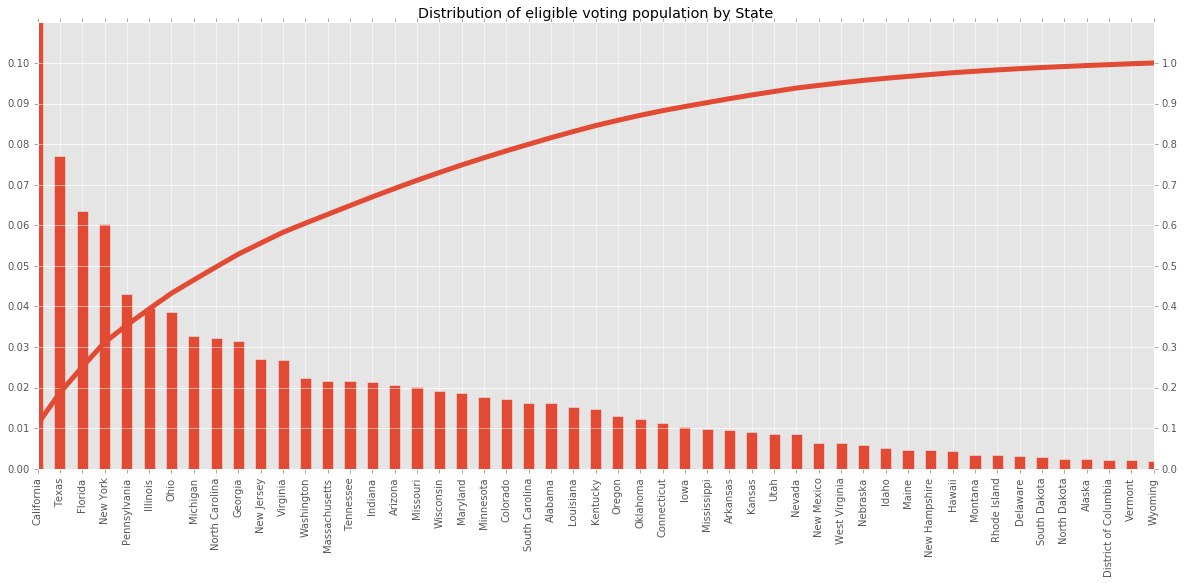

In [16]:
pdf_population = totals.sort_values(inplace=False, ascending=False) / totals.sum()
cum_population = pdf_population.cumsum()
fig, ax_1 = plt.subplots()
pdf_population.plot(kind='bar', figsize=(20, 8), ax=ax_1)
ax_2 = ax_1.twinx()
cum_population[pdf_population.index].plot(kind='line', ax=ax_2, rot=90, lw="5")
ax_1.set_ylim([0,.11])
ax_1.set_yticks(pd.np.arange(0,.11,.01))
ax_2.set_ylim([0,1.1])
ax_2.set_yticks(pd.np.arange(0,1.1,.1))
ax_1.set_title("Distribution of eligible voting population by State");

# Grab electoral college data

In [17]:
ELECTORAL_ALLOCATION_URL = "https://www.archives.gov/federal-register/electoral-college/print_friendly.html?page=allocation_content.html"

In [18]:
electoral_soup = BeautifulSoup(requests.get(ELECTORAL_ALLOCATION_URL).text, 'lxml')

In [19]:
tables = electoral_soup.findAll('table')

In [20]:
[t.attrs for t in tables]

[{'border': '0', 'cellpadding': '0', 'cellspacing': '0', 'width': '600'},
 {'border': '0', 'cellpadding': '0', 'cellspacing': '0', 'width': '600'},
 {'border': '0', 'cellpadding': '0', 'cellspacing': '0', 'width': '600'},
 {'border': '1', 'cellpadding': '4', 'width': '40%'},
 {'border': '0', 'cellpadding': '0', 'cellspacing': '0', 'width': '600'},
 {'border': '0', 'cellpadding': '0', 'cellspacing': '0'}]

In [21]:
# ...that's the one we're looking for
electoral_data = [t for t in tables if t.attrs['cellpadding']=='4'][0]
electoral_df = pd.read_html(str(electoral_data), header=0)[0].set_index('State')

In [22]:
electoral_df.head(20)

,Number of Electoral Votes
State,
Alabama,9
Alaska,3
Arizona,11
Arkansas,6
California,55
Colorado,9
Connecticut,7
Delaware,3
District of Columbia,3


In [23]:
electoral_df['total_votes'] = totals

In [24]:
electoral_df['electoral_votes_per_ballot'] = electoral_df['Number of Electoral Votes'] / electoral_df['total_votes']

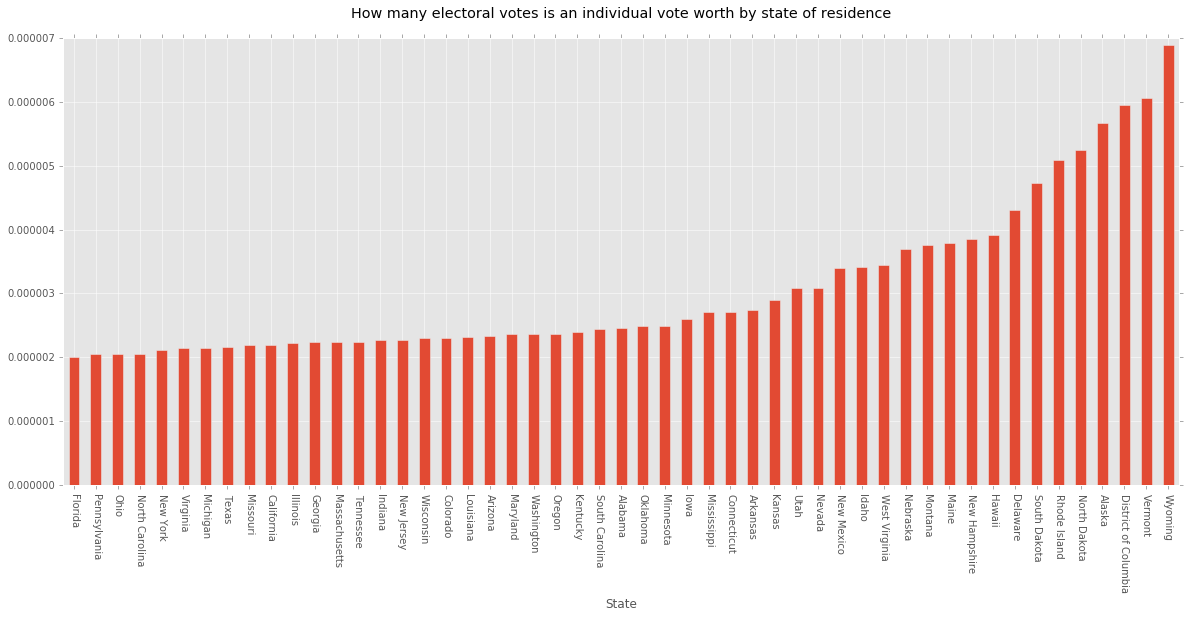

In [25]:
ax = electoral_df['electoral_votes_per_ballot'].sort_values().plot(kind='bar', figsize=(20,8), rot=-90)
ax.set_title("How many electoral votes is an individual vote worth by state of residence\n");

In [26]:
electoral_votes_by_race = pd.DataFrame(index = race_data.index)
for c in race_data:
    electoral_votes_by_race[c] = (race_data[c] * electoral_df['electoral_votes_per_ballot']).drop_duplicates()

In [27]:
electoral_votes_by_race.head()

,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,"White alone, Not Hispanic or Latino","Latino, white"
Alabama,2.36221,0.0365284,0.066462,0.00522995,0.029643,0.116951,6.27892,0.104057
Alaska,0.106564,0.387829,0.121437,0.0202121,0.0399812,0.194914,2.01657,0.112493
Arizona,0.486901,0.492636,0.265002,0.0190812,0.528069,0.25873,7.21418,1.7354
Arkansas,0.927342,0.0378328,0.0555276,0.00379645,0.0556374,0.0855835,4.71722,0.117056
California,3.77493,0.404506,7.40852,0.234597,5.26639,2.02978,26.3465,9.53477


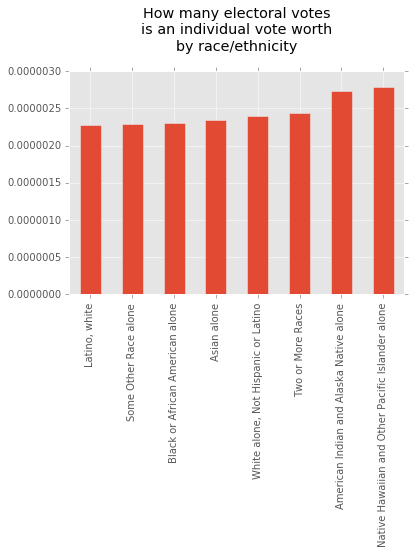

In [28]:
ax = (electoral_votes_by_race.sum() / race_data.sum()).sort_values().plot(kind='bar');
ax.set_title("How many electoral votes\nis an individual vote worth\nby race/ethnicity\n")

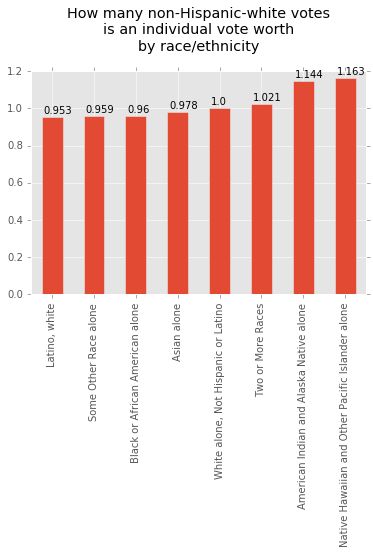

In [48]:
electoral_votes_by_race_agg = (electoral_votes_by_race.sum() / race_data.sum())
white_votes_per_vote = (electoral_votes_by_race_agg / electoral_votes_by_race_agg.loc[WHITE_NON_LATINO]).sort_values()
ax = white_votes_per_vote.sort_values().plot(kind='bar');
ax.set_title("How many non-Hispanic-white votes\nis an individual vote worth\nby race/ethnicity\n")
for (i, v) in enumerate(white_votes_per_vote.values):
    ax.annotate(round(v, 3), (i-.2, v+.02))

In [43]:
white_votes_per_vote.values

array([ 0.95340637,  0.95932579,  0.96003436,  0.9782382 ,  1.        ,
        1.02050238,  1.14437519,  1.16259768])

In [29]:
# Let's do the same thing for age...
age_data.head()

label,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over
Alabama,761260,872388,1262073,757660
Alaska,139756,138672,180313,69507
Arizona,1030287,1095389,1517363,1067409
Arkansas,457075,517354,737457,473838
California,5951295,6004043,8304470,4743004


In [30]:
electoral_votes_by_age = pd.DataFrame(index = age_data.index)
for c in age_data:
    electoral_votes_by_age[c] = (age_data[c] * electoral_df['electoral_votes_per_ballot']).drop_duplicates()

In [31]:
electoral_votes_by_age.head()

,18 to 29 years,30 to 44 years,45 to 64 years,65 years and over
Alabama,1.87534,2.1491,3.10908,1.86647
Alaska,0.793695,0.787539,1.02402,0.394741
Arizona,2.40596,2.55799,3.5434,2.49265
Arkansas,1.25471,1.42018,2.02438,1.30073
California,13.0914,13.2074,18.2678,10.4334


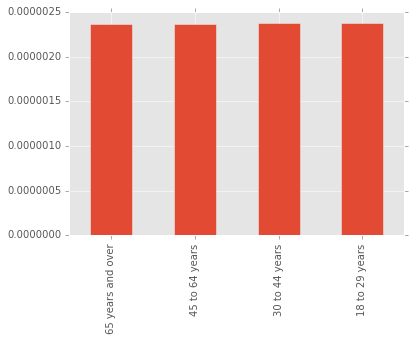

In [32]:
(electoral_votes_by_age.sum() / age_data.sum()).sort_values().plot(kind='bar');

In [33]:
# Let's do Non-latino whites vs everyone else
white_vs_not_white = race_data[[WHITE_NON_LATINO]]
white_vs_not_white.loc[:, 'Everyone else'] = race_data\
    .loc[:, [c for c in race_data.columns if c != WHITE_NON_LATINO]]\
    .sum(axis=1)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
electoral_votes_by_white = pd.DataFrame(index = white_vs_not_white.index)
for c in white_vs_not_white:
    electoral_votes_by_white[c] = (white_vs_not_white[c] * electoral_df['electoral_votes_per_ballot']).drop_duplicates()

In [35]:
electoral_votes_by_white.head()

,"White alone, Not Hispanic or Latino",Everyone else
Alabama,6.27892,2.721079
Alaska,2.01657,0.983430
Arizona,7.21418,3.785817
Arkansas,4.71722,1.282776
California,26.3465,28.653495


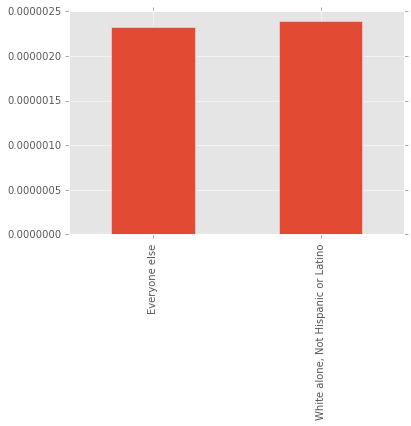

In [36]:
white_vs_not_white_vote_power = (electoral_votes_by_white.sum() / white_vs_not_white.sum()).sort_values()
white_vs_not_white_vote_power.plot(kind='bar');

In [37]:
# How many white votes is a non-white vote worth?
white_vs_not_white_vote_power.loc['Everyone else'] / white_vs_not_white_vote_power.loc[WHITE_NON_LATINO]

0.97071939925666939

In [38]:
# How many non-white votes is a white vote worth?
_**(-1)

1.0301638153783188